# 1. Observations on 1 pixel kernel

In Line (I), the operation ```self.in2out = nn.Conv2d(in_ch, out_ch, 1)``` is used to change the number of channels from in_ch to out_ch. By using a 1×1 kernel, this convolution applies a transformation independently to each pixel across channels. Instead of considering neighboring pixels, it performs a per-pixel operation, essentially appling learned linear transformation to each pixel's channel values. This allows for a channel-wise transformation while preserving spatial structure.

In Lines (K) and (L), the operations ```self.downsampler1 = nn.Conv2d(in_ch, in_ch, 1, stride=2)``` and ```self.downsampler2 = nn.Conv2d(out_ch, out_ch, 1, stride=2)``` serve as downsamplers. By setting stride=2, the convolution layer skips every other pixel in both the width and height dimensions. This results in a reduction of spatial resolution while performing a per-pixel linear transformation across channels. Unlike conventional convolution, which considers spatial neighbors, this method reduces the number of pixels processed while retaining key features.

The reason why Lines (I), (K), and (L) make sense in using a 1×1 kernel is that they perform a linear transformation at each pixel location while maintaining spatial information. Line (I) adjusts the number of channels without altering spatial dimensions, whereas Lines (K) and (L) downsample the feature map while preserving channel-wise structure. 


# 2. BMENet with maxpool

In [1]:
import os, sys
print(os.getcwd())
sys.path.append("./../DLStudio-2.5.1")

# from DLStudio import *

/home/chen4126/ece60146/HW6


Files already downloaded and verified
Files already downloaded and verified


The number of learnable parameters in the model: 30092354


Starting training loop...



[epoch:1/10  iter=1000  elapsed_time=   25 secs]   Ground Truth:           bird      plane       frog       ship        car       deer       frog       ship       deer      horse       bird       deer       frog        car        dog       ship
[epoch:1/10  iter=1000  elapsed_time=   25 secs]   Predicted Labels:      plane      plane        car        car        car       deer       deer       deer        dog        dog       bird        cat        dog        dog        dog       bird
[epoch:1/10  iter=1000  elapsed_time=   25 secs]   Loss: 2.278


[epoch:1/10  iter=2000  elapsed_time=   51 secs]   Ground Truth:           frog      plane        dog      truck        cat      horse        car       bird       deer       deer        car       frog      horse       bird      horse      horse
[epoch:1/10  iter=2000  elapsed_t

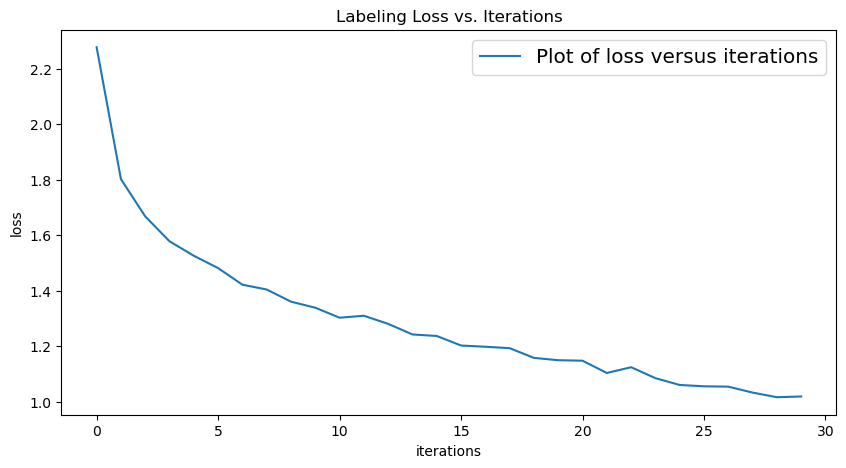

Prediction accuracy for plane : 65 %
Prediction accuracy for   car : 79 %
Prediction accuracy for  bird : 37 %
Prediction accuracy for   cat : 52 %
Prediction accuracy for  deer : 61 %
Prediction accuracy for   dog : 35 %
Prediction accuracy for  frog : 68 %
Prediction accuracy for horse : 70 %
Prediction accuracy for  ship : 81 %
Prediction accuracy for truck : 77 %



Overall accuracy of the network on the 10000 test images: 62 %


Displaying the confusion matrix:

           plane    car   bird    cat   deer    dog   frog  horse   ship  truck

 plane:    65.40   4.10   2.70   2.20   2.70   0.30   1.00   1.30  12.20   8.10
   car:     1.40  79.10   0.20   0.40   0.50   0.10   0.60   0.10   2.40  15.20
  bird:     9.80   2.20  37.30  11.20  17.30   5.20   5.00   4.50   4.30   3.20
   cat:     2.90   1.40   5.00  52.40  10.10   7.90   6.70   5.40   2.80   5.40
  deer:     2.50   0.80   5.80   7.60  61.60   2.20   5.60  11.00   1.60   1.30
   dog:     1.70   0.80   5.10  31.20   8.90  3

In [4]:
import torch.nn as nn
from DLStudio import DLStudio
import torch

# this code is mainly borrowed from DLstudio, the code that i modify has a comment behind
class BMEnetModifiedForMaxpool(nn.Module):
    def __init__(self, dl_studio, skip_connections=True, depth=8):
        super().__init__()

        self.dl_studio = dl_studio
        self.depth = depth
        image_size = dl_studio.image_size
        ## num_ds stands for number of downsampling steps
        num_ds = 0                  

        self.conv = nn.Conv2d(3, 64, 3, padding=1)

        # layers of skipblock without downsample
        self.skip64_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64_arr.append(self.SkipBlock(64, 64, skip_connections=skip_connections)) 
        # a skipblock with downsample
        self.skip64to128ds = self.SkipBlock(64, 128, downsample=True, skip_connections=skip_connections ) 
        num_ds += 1      

        self.skip128_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128_arr.append(self.SkipBlock(128, 128, skip_connections=skip_connections))
        self.skip128to256ds = self.SkipBlock(128, 256, downsample=True, skip_connections=skip_connections )
        num_ds += 1

        self.skip256_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip256_arr.append(self.SkipBlock(256, 256, skip_connections=skip_connections))

        self.fc1 =  nn.Linear( (image_size[0]// (2 ** num_ds))  *  (image_size[1]//(2 ** num_ds))  * 256, 1000)
        self.fc2 =  nn.Linear(1000, 10)



    def forward(self, x):
        x = nn.functional.relu(self.conv(x))          
        for skip64 in self.skip64_arr:
            x = skip64(x)                
        x = self.skip64to128ds(x)
        for skip128 in self.skip128_arr:
            x = skip128(x)                
        x = self.skip128to256ds(x)
        for skip256 in self.skip256_arr:
            x = skip256(x)                
        x  =  x.view( x.shape[0], - 1 )
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x            

    def load_cifar_10_dataset(self):       
        self.dl_studio.load_cifar_10_dataset()

    def load_cifar_10_dataset_with_augmentation(self):             
        self.dl_studio.load_cifar_10_dataset_with_augmentation()




    class SkipBlock(nn.Module):        
        def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
            super().__init__()
            self.downsample = downsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convo1 = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
            self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(in_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            self.in2out  =  nn.Conv2d(in_ch, out_ch, 1)       
            if downsample:
                self.maxpool = nn.MaxPool2d(2, 2) # do maxpool


        def forward(self, x):
            # identity holds the original input tensor to the skip block
            identity = x                                     
            out = self.convo1(x)                              
            out = self.bn1(out)                              
            out = nn.functional.relu(out)
            out = self.convo2(out)                              
            out = self.bn2(out)                              
            out = nn.functional.relu(out)


            # Apply downsampling if needed
            if self.downsample:
                identity = self.maxpool(identity)       # channel still input size 
                out = self.maxpool(out)                #  channel still output size
                
            # Handle skip connections
            if self.skip_connections:
                if (self.in_ch == self.out_ch) and (self.downsample is False):
                    out = out + identity
                elif (self.in_ch != self.out_ch) and (self.downsample is False):
                    identity = self.in2out( identity )     
                    out = out + identity
                elif (self.in_ch != self.out_ch) and (self.downsample is True):
                    out = out + torch.cat((identity, identity), dim=1)

            return out


    def run_code_for_training(self, net, display_images=False):        
        self.dl_studio.run_code_for_training(net, display_images)
        
    def save_model(self, model):
        '''
        Save the trained model to a disk file
        '''
        torch.save(model.state_dict(), self.dl_studio.path_saved_model)

    def run_code_for_testing(self, model, display_images=False):
        self.dl_studio.run_code_for_testing(model, display_images=False)


dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/CIFAR-10/",
                dataroot = "./../data/CIFAR-10/",
                image_size = [32,32],
                path_saved_model = "./saved_model",
                momentum = 0.9,
                learning_rate = 1e-5,
                epochs = 10,
                batch_size = 16,
                classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck'),
                use_gpu = True,
            )

bme_net = BMEnetModifiedForMaxpool(dls, skip_connections=True, depth=8)         ## if you want to use skips

bme_net.load_cifar_10_dataset()

## display network properties
number_of_learnable_params = sum(p.numel() for p in bme_net.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)

## training and testing
bme_net.run_code_for_training(bme_net, display_images=False)
bme_net.run_code_for_testing(bme_net, display_images=False)


### 2.1 Train loss curve
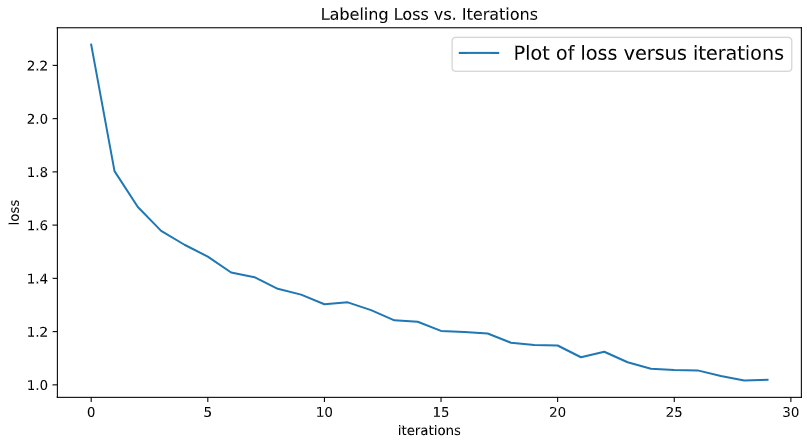

### 2.2 Confusion Matrix
|        | Plane | Car  | Bird | Cat  | Deer | Dog  | Frog | Horse | Ship | Truck |
|--------|-------|------|------|------|------|------|------|-------|------|-------|
| **Plane** | 65.40 | 4.10 | 2.70 | 2.20 | 2.70 | 0.30 | 1.00 | 1.30  | 12.20 | 8.10  |
| **Car**   | 1.40  | 79.10 | 0.20 | 0.40 | 0.50 | 0.10 | 0.60 | 0.10  | 2.40  | 15.20 |
| **Bird**  | 9.80  | 2.20 | 37.30 | 11.20 | 17.30 | 5.20 | 5.00 | 4.50  | 4.30  | 3.20  |
| **Cat**   | 2.90  | 1.40 | 5.00 | 52.40 | 10.10 | 7.90 | 6.70 | 5.40  | 2.80  | 5.40  |
| **Deer**  | 2.50  | 0.80 | 5.80 | 7.60 | 61.60 | 2.20 | 5.60 | 11.00 | 1.60  | 1.30  |
| **Dog**   | 1.70  | 0.80 | 5.10 | 31.20 | 8.90 | 35.50 | 2.40 | 8.80  | 2.70  | 2.90  |
| **Frog**  | 0.60  | 1.70 | 4.00 | 8.50 | 10.20 | 0.40 | 68.20 | 1.60  | 1.50  | 3.30  |
| **Horse** | 1.40  | 0.60 | 2.00 | 7.10 | 8.10 | 3.20 | 1.00 | 70.00 | 0.60  | 6.00  |
| **Ship**  | 4.90  | 5.40 | 0.20 | 0.90 | 0.70 | 0.00 | 0.50 | 0.80  | 81.90 | 4.70  |
| **Truck** | 2.30  | 12.30 | 0.40 | 1.60 | 0.70 | 0.00 | 0.80 | 1.10  | 3.10  | 77.70 |


# 3. BMENet with stride

ter=3000  elapsed_time=   93 secs]   Loss: 1.641


[epoch:1/6  iter=4000  elapsed_time=  122 secs]   Ground Truth:          horse      plane       ship        dog
[epoch:1/6  iter=4000  elapsed_time=  122 secs]   Predicted Labels:       ship      plane       ship       frog
[epoch:1/6  iter=4000  elapsed_time=  122 secs]   Loss: 1.556


[epoch:1/6  iter=5000  elapsed_time=  151 secs]   Ground Truth:          plane       bird      plane        car
[epoch:1/6  iter=5000  elapsed_time=  151 secs]   Predicted Labels:      plane       frog        dog        car
[epoch:1/6  iter=5000  elapsed_time=  151 secs]   Loss: 1.478


[epoch:1/6  iter=6000  elapsed_time=  181 secs]   Ground Truth:          plane       ship       deer        cat
[epoch:1/6  iter=6000  elapsed_time=  181 secs]   Predicted Labels:       bird       ship        dog        cat
[epoch:1/6  iter=6000  elapsed_time=  181 secs]   Loss: 1.384


[epoch:1/6  iter=7000  elapsed_time=  210 secs]   Ground Truth:           ship      h

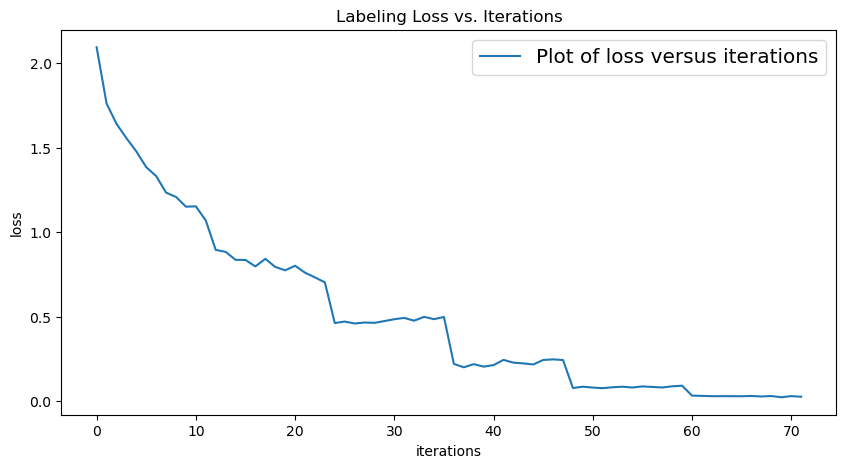

/home/chen4126/ece60146/HW6/./../DLStudio-2.5.1/DLStudio/DLStudio.py:2964: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.path_saved_model

In [3]:
# this code is mainly borrowed from DLstudio

dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/CIFAR-10/",
                dataroot = "./../data/CIFAR-10/",
                image_size = [32,32],
                path_saved_model = "./saved_model",
                momentum = 0.9,
                learning_rate = 1e-4,
                epochs = 6,
                batch_size = 4,
                classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck'),
                use_gpu = True,
            )

bme_net = dls.BMEnet(dls, skip_connections=True, depth=8)         ## if you want to use skips

bme_net.load_cifar_10_dataset()

## display network properties
number_of_learnable_params = sum(p.numel() for p in bme_net.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)

## training and testing
bme_net.run_code_for_training(bme_net, display_images=False)
bme_net.run_code_for_testing(bme_net, display_images=False)


### 3.1 Train loss curve
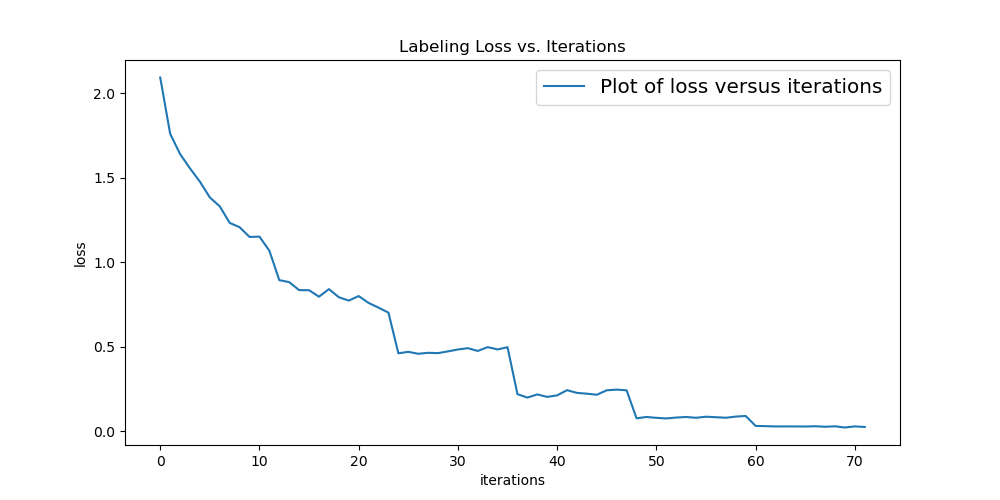

### 3.2 Confusion Matrix
|        | Plane  | Car   | Bird  | Cat   | Deer  | Dog   | Frog  | Horse | Ship  | Truck |
|--------|--------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| **Plane** | 78.10  | 1.60  | 7.50  | 2.30  | 0.70  | 0.50  | 1.20  | 0.50  | 4.60  | 3.00  |
| **Car**   | 0.30  | 93.20 | 0.10  | 0.60  | 0.00  | 0.10  | 1.00  | 0.10  | 1.40  | 3.20  |
| **Bird**  | 3.60  | 0.60  | 73.90 | 6.20  | 4.40  | 4.20  | 3.90  | 1.30  | 1.00  | 0.90  |
| **Cat**   | 1.00  | 0.70  | 6.10  | 67.60 | 3.10  | 12.00 | 5.40  | 2.30  | 1.20  | 0.60  |
| **Deer**  | 1.30  | 0.60  | 8.10  | 6.80  | 71.30 | 2.30  | 4.80  | 4.40  | 0.40  | 0.00  |
| **Dog**   | 0.90  | 0.20  | 4.00  | 18.70 | 1.50  | 68.20 | 2.20  | 3.50  | 0.40  | 0.40  |
| **Frog**  | 0.40  | 0.60  | 3.70  | 5.70  | 1.20  | 1.00  | 86.70 | 0.10  | 0.40  | 0.20  |
| **Horse** | 1.40  | 0.10  | 2.60  | 5.20  | 2.80  | 3.60  | 0.60  | 82.60 | 0.20  | 0.90  |
| **Ship**  | 3.50  | 3.40  | 1.30  | 1.10  | 0.30  | 0.50  | 0.70  | 0.10  | 87.50 | 1.60  |
| **Truck** | 2.00  | 7.30  | 0.80  | 2.10  | 0.30  | 0.40  | 0.60  | 0.80  | 1.50  | 84.20 |


# 4. Table1: Overall accuracy of 2 models table
|   | Maxpool | Stride|
|---|---------|-------|
| Accuracy| 62%| 79%|

# 5. Table2: Per class accuracy of 2 models (10x2 table)
|        | Maxpool  | Stride   | 
|--------|--------|-------|
| **Plane** |  65 | 78  | 
| **Car**   |  79 | 93 | 
| **Bird**  |  37 | 73  | 
| **Cat**   |  52 | 67  | 
| **Deer**  |  61 | 71  | 
| **Dog**   |  35| 68  | 
| **Frog**  |  68 | 86  |
| **Horse** |  70 | 82  | 
| **Ship**  |  81 | 87  | 
| **Truck** |  77 | 84  | 




# 6. Observations of Maxpool vs Stride

Conclusion first, the stride method significantly outperforms the maxpool method in this experiment.

The likely reason for this difference is that, while both approaches aim to reduce spatial dimensions, the stride method learns how to downsample the image while simultaneously extracting relevant features. In contrast, max pooling is a fixed operation that simply selects the most prominent value in a local region, without learning additional transformations that might preserve more discriminative information.

When using stride-based convolutions, the network jointly optimizes feature extraction and downsampling, ensuring that critical patterns are retained even as resolution decreases. This allows for a more adaptive reduction in spatial dimensions, where the network can learn to emphasize key edges, textures, or shapes based on training data.

On the other hand, MaxPooling is a static operation—it does not learn any parameters, and it simply selects the maximum value from a given region. While this can help with translation invariance, it may also result in information loss, as it discards non-maximum activations that could be useful in later layers. This rigid downsampling process might lead to a degradation in representational power, making it harder for the model to distinguish between similar classes effectively.

Given these findings, stride-based downsampling appears to be a more effective strategy for this particular architecture and dataset.

Furthermore, compared to HW5, where I used max pooling without shortcut connections, the current model shows significant improvement in performance. This suggests that both stride-based downsampling and shortcut connections contribute to better feature retention and overall model efficiency.

# 7. Skip Connections with MSCOCO

In [ ]:
import torch.nn as nn
# skipblock is borrowed from DLstudio
class SkipBlock(nn.Module):
    """
    Class Path:   DLStudio  ->  BMEnet  ->  SkipBlock
    """            
    def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
        super().__init__()
        self.downsample = downsample
        self.skip_connections = skip_connections
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.convo1 = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.in2out  =  nn.Conv2d(in_ch, out_ch, 1)       
        if downsample:
            ##  Setting stride to 2 and kernel_size to 1 amounts to retaining every
            ##  other pixel in the image --- which halves the size of the image:
            self.downsampler1 = nn.Conv2d(in_ch, in_ch, 1, stride=2)
            self.downsampler2 = nn.Conv2d(out_ch, out_ch, 1, stride=2)

    def forward(self, x):
        identity = x                                     
        out = self.convo1(x)                              
        out = self.bn1(out)                              
        out = nn.functional.relu(out)
        out = self.convo2(out)                              
        out = self.bn2(out)                              
        out = nn.functional.relu(out)
        if self.downsample:
            identity = self.downsampler1(identity)
            out = self.downsampler2(out)
        if self.skip_connections:
            if (self.in_ch == self.out_ch) and (self.downsample is False):
                out = out + identity
            elif (self.in_ch != self.out_ch) and (self.downsample is False):
                identity = self.in2out( identity )     
                out = out + identity
            elif (self.in_ch != self.out_ch) and (self.downsample is True):
                out = out + torch.cat((identity, identity), dim=1)
        return out



# ------------------ HW6 NET------------------
# some of this code is borrowed from DLstudio, the code that i modify has a comment behind

class HW6Net(nn.Module): # nn.Module is the base class for all neural network models in PyTorch. Every deep learning model you create should inherit from nn.Module
    def __init__(self, num_class = 5, skip_connections=True):
        super().__init__()
        num_ds = 0 
         
        self.depth = 6 # Since each SkipBlock uses two instances of nn.Conv2d, your network will need to contain at least 20 instances of SkipBlock. we have THREE for loops, so there should be 3*6+3+1=22 skipblocks!

        self.initial_block = SkipBlock(3, 64, skip_connections=False)  # this is just like conv2d. But we don't use conv2d in this exercise. The reason that this is like connv2d is because we set skipconnection = false, so that channel will not mismatch in shortcut (32!=64)


        # these for loop block is mainly borrow from DLstudio, but I added a additional for loop and some extra downsampling
        self.skip64_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64_arr.append(SkipBlock(64, 64, skip_connections=skip_connections))
        self.skip64to128ds = SkipBlock(64, 128, downsample=True, skip_connections=skip_connections )
        num_ds += 1              

        self.skip128_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128_arr.append(SkipBlock(128, 128, skip_connections=skip_connections))
        self.skip128to256ds = SkipBlock(128, 256, downsample=True, skip_connections=skip_connections )
        num_ds += 1

        self.skip256_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip256_arr.append(SkipBlock(256, 256, skip_connections=skip_connections))



        self.fc1 =  nn.Linear( (32// (2 ** num_ds))  *  (32//(2 ** num_ds))  *256, 512) # we resize the image to 32x32 in transform
        self.fc2 =  nn.Linear(512, num_class) # reduce the size of fc layers

    def forward(self, x):

        x = self.initial_block(x)  # initial block 3->64

        for skip64 in self.skip64_arr:
            x = skip64(x)                
        x = self.skip64to128ds(x)
        for skip128 in self.skip128_arr:
            x = skip128(x)                
        x = self.skip128to256ds(x)
        for skip256 in self.skip256_arr:
            x = skip256(x)                


        x  =  x.view( x.shape[0], - 1 )
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x     



### 7.1 5x3 images

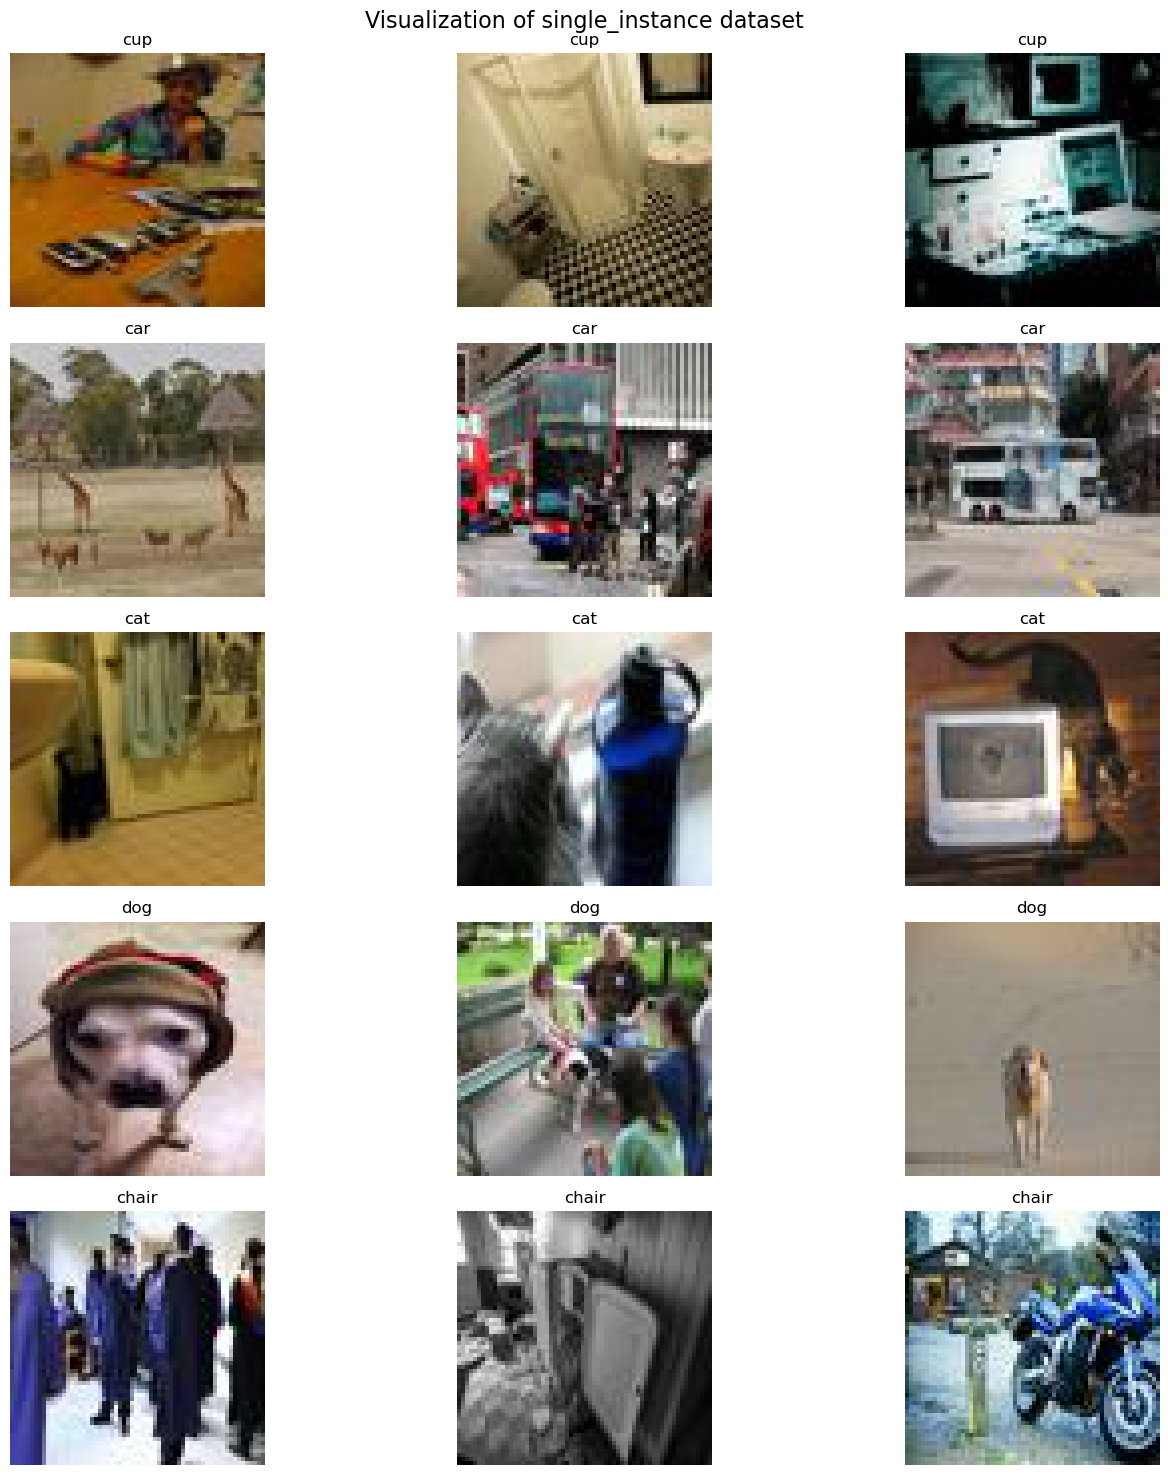

In [19]:
import matplotlib.pyplot as plt
import random

def visualize_dataset(dataset_type, classes, output_dir="output_datasets"):
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))  # 5 rows x 3 columns grid
    fig.suptitle(f"Visualization of {dataset_type} dataset", fontsize=16)
    
    image_paths = []
    
    for category in classes:
        category_path = os.path.join(output_dir, dataset_type, 'train', category)
        if os.path.exists(category_path) and os.listdir(category_path):
            category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)] 
            random.shuffle(category_images)
            image_paths.extend(category_images[:3]) # Select 3 images per class
    
    image_paths = image_paths[:15]  # Ensure only 15 images for the grid
    
    for ax, img_path in zip(axes.ravel(), image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(os.path.dirname(img_path)))  # Display category name
    
    plt.tight_layout()
    plt.show()

target_classes = ["cup", "car", "cat", "dog", "chair"]

visualize_dataset("single_instance", target_classes)

### 7.2 train loss curve

Using device: cuda
Epoch [1/20], Loss: 2.5548, Train Acc: 28.43%
Epoch [2/20], Loss: 1.5079, Train Acc: 35.45%
Epoch [3/20], Loss: 1.4601, Train Acc: 38.46%
Epoch [4/20], Loss: 1.4457, Train Acc: 38.84%
Epoch [5/20], Loss: 1.4284, Train Acc: 39.43%
Epoch [6/20], Loss: 1.4088, Train Acc: 40.88%
Epoch [7/20], Loss: 1.3817, Train Acc: 41.74%
Epoch [8/20], Loss: 1.3870, Train Acc: 42.13%
Epoch [9/20], Loss: 1.3996, Train Acc: 42.59%
Epoch [10/20], Loss: 1.3493, Train Acc: 44.06%
Epoch [11/20], Loss: 1.3498, Train Acc: 44.86%
Epoch [12/20], Loss: 1.3263, Train Acc: 45.61%
Epoch [13/20], Loss: 1.3254, Train Acc: 45.49%
Epoch [14/20], Loss: 1.3353, Train Acc: 45.14%
Epoch [15/20], Loss: 1.3232, Train Acc: 45.40%
Epoch [16/20], Loss: 1.3035, Train Acc: 46.54%
Epoch [17/20], Loss: 1.2842, Train Acc: 47.52%
Epoch [18/20], Loss: 1.2644, Train Acc: 48.37%
Epoch [19/20], Loss: 1.2573, Train Acc: 48.90%
Epoch [20/20], Loss: 1.2459, Train Acc: 49.38%


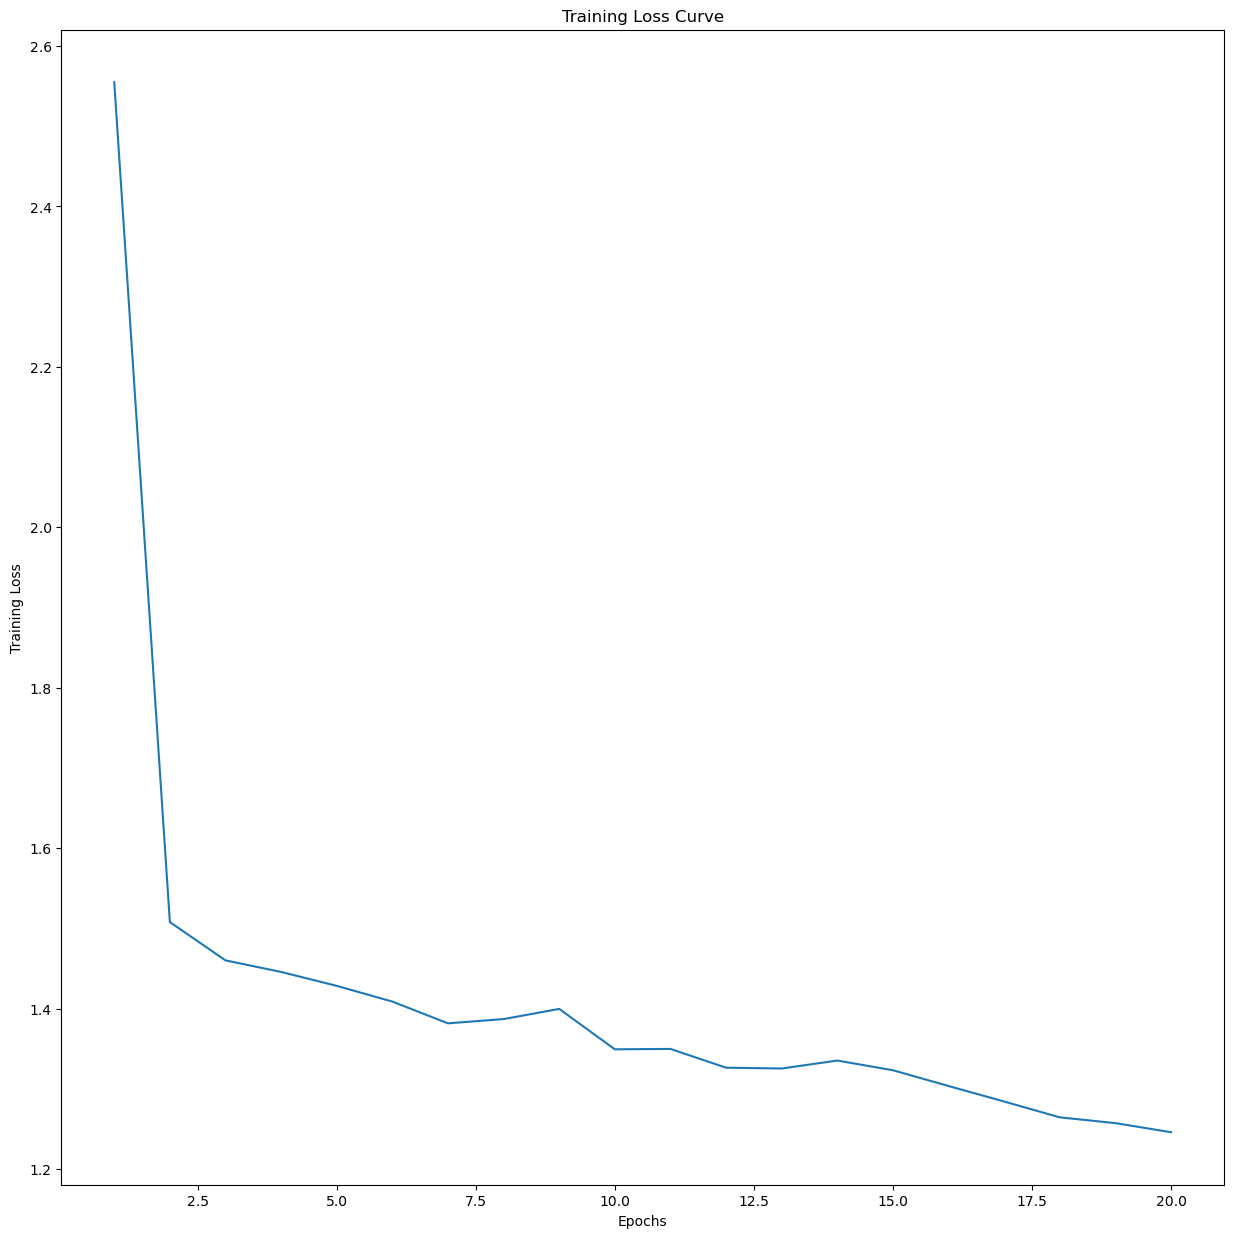

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=5),  
    transforms.Resize((32, 32)),  # Resize images to 32x32 for consistency
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

transform_val = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32 for consistency
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load training dataset
train_dataset = torchvision.datasets.ImageFolder(root="output_datasets/train", transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load validation dataset
val_dataset = torchvision.datasets.ImageFolder(root="output_datasets/val", transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)




# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = HW6Net().to(device)  # move model to gpu

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for multi-class classification


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3) # use weight decay to prevent overfitting



# ---------train loop------------

# Modify train function to store training loss
def train_model(model, train_loader, criterion, optimizer, epochs):
    train_losses = []  # Store training losses
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # move data to gpu

            optimizer.zero_grad() # zero the parameter gradients to prevent accumulation of gradients
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # calculate loss
            loss.backward() # backward pass
            optimizer.step() # update weights

            running_loss += loss.item() # accumulate loss
            _, predicted = torch.max(outputs, 1) # get the class label with the highest probability
            total += labels.size(0) # accumulate total number of labels
            correct += (predicted == labels).sum().item() # accumulate correct predictions

        train_losses.append(running_loss / len(train_loader)) # store average loss per epoch 

        train_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%")
    
    return train_losses

train_losses = train_model(model, train_loader, criterion, optimizer, epochs=20) # store loss history for further use

# ---------end train loop------------

# ----- train loss curve -----
plt.figure(figsize=(15, 15))
plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()










### 7.3 conf matrix 5x5

Overall Validation Accuracy: 41.16%


<Figure size 600x600 with 0 Axes>

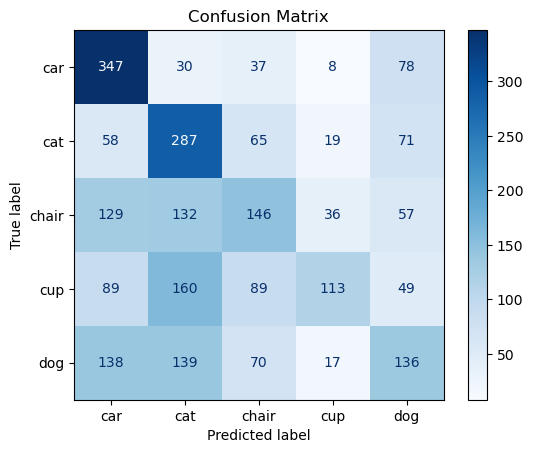

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad(): # disable gradient calculation  to save memory for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


# Get true labels and predictions
true_labels, predicted_labels = evaluate_model(model, val_loader)

# Compute overall accuracy by using sklearn
overall_acc = accuracy_score(true_labels, predicted_labels)
print(f"Overall Validation Accuracy: {overall_acc * 100:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

### 7.4 overall accuracy
Overall Validation Accuracy: 41.16%


### 7.5 per class accuracy 5x1 table

| Class | Accuracy(%)|
|-------|-----|
| Car |   69|
| Cat |  57|
| Chair |  29|
| Cup | 22 |
| Dog | 27 |


### 7.6 observations

Initially, I expected that using 64×64 images would yield better performance. However, not only did training with 64×64 inputs take significantly longer, but the results were also comparable to 32×32 images.

One major issue I encountered was severe overfitting—the training accuracy reached 90%, while validation accuracy remained around 40%.  I believe the primary reason for this is that I’m using a 22-layer deep convolutional neural network and 2-layer fully connected layers on a relatively simple dataset, which likely causes the model to memorize training samples rather than generalize effectively.

To address this, I experimented with various hyperparameters, such as reducing the batch size, increasing the weight decay, and increasing learning rate. While these adjustments helped mitigate overfitting, I still struggled to push validation accuracy beyond 50%. (41%)

Since the architecture closely resembles the one used for CIFAR-10 (BMENet), I believe the primary issue is not the model itself. Instead, the COCO dataset poses additional challenges due to its complexity and dense object compositions. A model better suited for object detection, such as YOLO, might yield improved performance. Further investigation is required to pinpoint the underlying factors affecting performance.